## Hierarchical spatial allocation model for mental health specialist assignments to schools
+ Assume specialists will work exclusively within an administrative zone (here using school districts)
+ Assume specialists have the same skillset, ie no reason specific specialist needs to be assigned to a specific school / school district
+ Each school has some quantifiable need for a specialist, here we assume it is based on (a) neighborhood characteristics and (b) the number of students -> built in room to add school performance metrics

In [1]:
# load libraries
import math
import numpy as np
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
#import shapely.geometry as geom
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors as NN

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
### read in base data
# NY school districts
nysd = gpd.read_file('../inputs/nysd_15d/nysd.shp')
# NY school points
schools = gpd.read_file('../inputs/Public_School_Locations/public_schools_2011-2012A.geojson')
# NY United Hospital Fund zones with 2009 Community Health Survey results and count of schools per zone
UHF_CHS = gpd.read_file('../inputs/CHS09_SchoolCount.geojson')

### team inputs
# socioeconomic data for school districts
socioecon = pd.read_pickle('../inputs/team/socioeconomic.pkl')
# school data (a) school district graduation rates (b) school attendence and more
sd_grad = pd.read_csv('../inputs/team/SD_GRAD.csv')
schoolAttend = pd.read_csv('../inputs/team/school_data_and_coords.csv')
# mental health data
chs_agg = pd.read_csv('../inputs/team/chs_aggregated.csv')

In [3]:
# project school districts to same as schools (WGS84)
nysd.to_crs(schools.crs, inplace=True)

In [4]:
# get lat/lon coordinates for plotting
schools['lat'] = schools.geometry.apply(lambda x: x.centroid.y)
schools['lon'] = schools.geometry.apply(lambda x: x.centroid.x)

In [ ]:
# check out input data's columns
print nysd.columns.tolist()
print 
print schools.columns.tolist()
print 
print socioecon.columns.tolist()
print
print sd_grad.columns.tolist()
print
print schoolAttend.columns.tolist()
print
print UHF_CHS.columns.tolist()
print
print chs_agg.columns.tolist()

In [5]:
# get index as column and update to match CHS survey data
UHF_CHS.reset_index(inplace=True)
UHF_CHS.loc[:,'index'] += 1

In [6]:
# subset and merge UHF shapes with CHS data
UHF_CHS = gpd.GeoDataFrame(pd.merge(UHF_CHS.loc[:,('index', 'geometry')], chs_agg, 
                                    left_on='index', right_on='uhf34'))
# reseting deletes crs, so also reset it
UHF_CHS.crs = schools.crs

In [7]:
# join works fine, but what code are we joining the CHS-aggregated data on?
schools = sjoin(schools, UHF_CHS, how='left')
#schools.info()

In [8]:
# keeping prototype simple - what other school data do we want to include in this round?
schools = gpd.GeoDataFrame(pd.merge(schools, schoolAttend.loc[:,('LOC_CODE', 'Total Enrollment')],
                                   left_on='LOC_CODE', right_on='LOC_CODE'))
#schools.info()

In [ ]:
''' More mapping functionality when ready
plt.rcParams.update({'font.size': 16})
nK = 7
# zipcode is a GeoDataFrame of zipcode polygons, calling .plot() returns a pyplot axis object
ax = zipcodes.plot(column='wGoodParks_d1', figsize=(16,12), 
                   scheme='QUANTILES', k=nK, alpha=1, cmap='YlGn')
f = ax.get_figure()
ax1 = f.add_subplot(111) # this is strictly to add the color bar

# sloppy, imagine there's a better way but this works OK for me
vals = [round(np.percentile(zipcodes.wGoodParks_d1, c*100/nK), 2) for c in range(nK+1)]
grid = np.array([vals, vals])
img = ax1.imshow(grid, cmap=plt.get_cmap('YlGn'))

cbaxes = f.add_axes([0.21, 0.82, 0.3, 0.05]) 
cb = plt.colorbar(img, cax = cbaxes, orientation='horizontal', ticks=[0, vals[-1]/2, vals[-1]])
cb.set_label('Access to parks \n(park area / distance to park)')
cb.ax.set_xticklabels(['Low', 'Medium','High'])

ax.set_xlabel('Easting (feet)')
ax.set_ylabel('Northing (feet)')
ax.set_title('TASK 4 part 2: Chloropleth of park access metric by zipcdoe')

ax1.remove()
'''

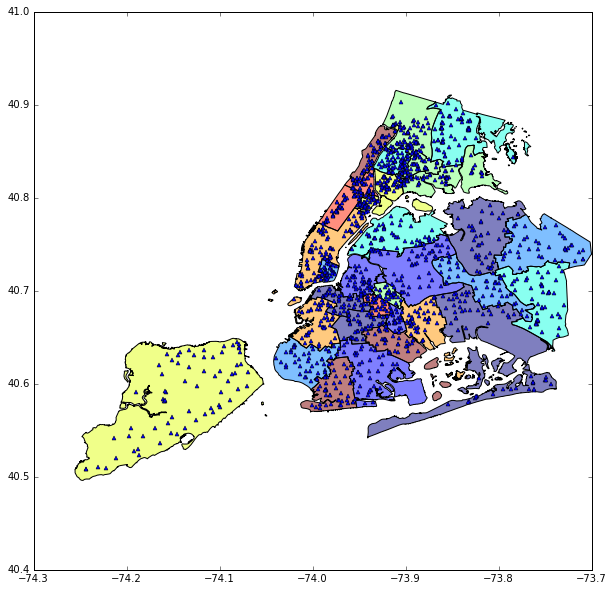

In [9]:
# f, ax = plt.subplots(figsize=(12,10))
ax = nysd.plot(figsize=(12,10))
#f = ax.get_figure()
#ax1 = f.add_axes(schools.plot())
ax.plot(schools.lon, schools.lat, '^', markersize=4)
# ax.plot(schools.lon[schools.GEO_DISTRI==0], schools.lat[schools.GEO_DISTRI==0], '^r', markersize=8)

### Prepare data
+ need to get to single value for "demand" at both district and school level

In [10]:
# first check for duplicates of base data
nysd[nysd.SchoolDist.duplicated()]

,SchoolDist,Shape_Area,Shape_Leng,geometry
32,10,3282963.20003,7883.372435,(POLYGON ((-73.90893235175379 40.8721573480034...


In [11]:
# check duplicates and decide which to delete
nysd[nysd.SchoolDist==10]

,SchoolDist,Shape_Area,Shape_Leng,geometry
22,10,2.825398e+08,94971.138984,POLYGON ((-73.86789043713642 40.90298695418564...
32,10,3.282963e+06,7883.372435,(POLYGON ((-73.90893235175379 40.8721573480034...


In [12]:
# drop little piece of district - could also join it but this is easier and shouldn't matter
nysd = gpd.GeoDataFrame(nysd[~(nysd.index==32)])
# nysd.info()

In [ ]:
#schools.groupby('GEO_DISTRI')['Total Enrollment'].agg({'TotalEnrollment': np.sum, 'SchoolCount': 'count'})

In [13]:
# join summarized school metrics to districts (prototype just using total enrollment)
nysd = pd.merge(nysd, schools.groupby('GEO_DISTRI')['Total Enrollment'].agg({'TotalEnrollment': np.sum, 
                                                                             'SchoolCount': 'count'}), 
                left_on='SchoolDist', right_index=True)
#nysd.info()

In [14]:
# and summarized mental health data
nysd = pd.merge(nysd, schools.groupby('GEO_DISTRI')['agg_mood', 'nspd'].mean(), 
                left_on='SchoolDist', right_index=True)

In [15]:
nysd.drop(['Shape_Area', 'Shape_Leng'], axis=1, inplace=True)
#nysd.info()

In [16]:
# add inverse of graduation rate to School Districts
sd_grad['NoGradRate'] = 1 - sd_grad.percent_of_grads
#sd_grad.reset_index(inplace=True)
#sd_grad.head(2)

In [17]:
nysd = pd.merge(nysd, sd_grad.loc[:,('NoGradRate', 'GEO_DISTRI')], left_on='SchoolDist', right_on='GEO_DISTRI')
nysd.drop('GEO_DISTRI', inplace=True, axis=1)
#nysd.head()

In [18]:
# inverse relative median income
socioecon['RelMedInc'] = 1 - (socioecon['Median income (dollars)'] / socioecon['Median income (dollars)'].max())
# percent of district's families without employment in last 12 months
socioecon['PctNoWorkers'] = socioecon['No workers in the past 12 months (%)'] / 100
# percent with high school or less
socioecon['PctHSorLess'] = 1 - (socioecon['Percent bachelor\'s degree or higher'] / 100)
#socioecon.head()

In [19]:
# add socioeconomic data to school district
nysd = pd.merge(nysd, socioecon.loc[:,('RelMedInc', 'PctNoWorkers', 'PctHSorLess')], 
                left_on='SchoolDist', right_index=True)
#nysd.head()

In [20]:
# Relative enrollment
nysd['RelEnroll'] = nysd.TotalEnrollment / nysd.TotalEnrollment.max()
#nysd.head(3)

In [21]:
# create 0-1 normalized value for mental health indicators
nysd['RelNSPD'] = nysd.nspd / nysd.nspd.max()

# higher values mean *happier*, so take inverse for 'need' metric
nysd['RelMood'] = 1 - (nysd.agg_mood / nysd.agg_mood.max()) 

In [22]:
print 'confirm unique code for schools', len(schools), len(schools.LOC_CODE.unique())
print 'and for districts', len(nysd), len(nysd.SchoolDist.unique())

confirm unique code for schools 1598 1598
and for districts 32 32


### District level allocation
top down model - within district only

#### set input parameters
1. weights of demand / need metric
2. number of specialists to assign
3. maximum schools per specialist per month (note: model will likely produce territories with more schools than the maximum number due to geographic distribution of schoools, so set lower than actual maximum desired)

In [23]:
# componenet multipliers - how heavily should each metric be weighted on a 0 - 1 scale?
# DOE / school data
studentM = 1 # weight for relative number of students
gradM = 1 # weight for inverse graduation rate of high schools in district
# socioeconomic multipliers
incomeM = 0.5 # weight for relative median income
employM = 0.5 # weight for percent of district's families that did not have a job in the last 12 months
educatM = 0.5 # weight for percent of district with a High School degree or less education
# UHF mental health indicators
moodM = 1 # weight value for neighborhood mood metric
nspdM = 1 # weight value for neighborhood respondonts


# calculate single specialist demand metric from component parts
nysd['Demand'] = nysd.loc[:,'RelEnroll']*studentM + nysd.loc[:,'NoGradRate']*gradM + \
nysd.loc[:,'RelMedInc']*incomeM + nysd.loc[:,'PctNoWorkers']*employM + nysd.loc[:,'PctHSorLess']*educatM + \
nysd.loc[:, 'RelMood']*moodM + nysd.loc[:,'RelNSPD']*nspdM

In [24]:
# specialist list for analysis - key set up to handle any number of specialists up to 1,000
### How many specialists are we assigning?
NumSpecialists = 100 
sKeys = ['s' + ('00'+str(i))[-3:] for i in range(NumSpecialists)]

In [25]:
### make minimum constraint based on ensuring every school has ~1 day per month with a specialist
MaxSchoolsPerMonth = 20
#print nysd.SchoolCount.sum() / float(len(sKeys))
#print sum(np.ceil(nysd.SchoolCount / MaxSchoolsPerMonth))

#### function to assign specialists to districts
if possible makes total number of schools in a district is less than the number of specialists multiplied by the number of schools allowed per month

In [26]:
# assign specialists to districts 
# initial step: iterate through list of specialists assigning each to a school district
# @Params: 
### specList = list, agents' (specialists') unique identifiers, will be key of returned dictionary
### District = pandas.DataFrame, district within which to assign specialists
### Did = district ID column
### demandColumn = column name of value to split amongst agents in District DataFrame
### locCount = number of physical locations (for us: schools)
### maxLocs = maximum number of locations an agent can visit per month (eg 0.5 day per school, ~20 days in a month)
# @return - agentDict = {agentID: DistrictCode}
# @return - distDict = {DistrictID: {agents: [AgentID]}}
def assignToDistrict(agentList, District, Did, demandColumn, locCount, maxLocs):
    # temporary DataFrame for function
    tmp = pd.DataFrame(District.loc[:,(Did, demandColumn, locCount)])
    # get 'optimal' (average) demand per agent
    targetDemand = tmp[demandColumn].sum() / len(agentList)
    
    # 'minAgent' tells how many agents need to be assigned so district does not 
    ## have more locations than agents can visit
    tmp['minAgent'] = np.ceil(tmp[locCount] / maxLocs)
    
    # once minumum number of agents assigned, demandR is remaining demand
    tmp['demandR'] = tmp[demandColumn] - (tmp.minAgent * targetDemand)
    # tmp.sort_values(by='demandR', ascending=False, inplace=True) # unnecessary
    
    # district dictionary for output
    distDict = dict(zip(tmp[Did], tmp[Did]))
    for i in distDict.keys():
        distDict[i] = {} # reset each district to be an object
        distDict[i]['agents'] = [] # create array to hold agent IDs
    
    # agent dictionary to for output assignments
    agentDict = {}
    # iterate through agent IDs assigning to districts based on minumum agent number, then demand remaining
    Didx = 0 # row index to track which is *this* District
    aN = 0 # number of assigned agents for *this* district
    for a in agentList:
        #print 'agent ', a
        if aN < tmp.loc[Didx:Didx, :]['minAgent'].values[0]:
            agentDict[a] = {'district': ''}
            agentDict[a]['district'] = tmp.loc[Didx:Didx, :][Did].values[0]
            distDict[agentDict[a]['district']]['agents'].append(a) # add agent ID to agents serving this district
            aN += 1
#            print '1. assigned to {0} | aN={1} | minAgent={2} | Didx={3} |demandR={4}'.format(\
#agentDict[a], aN, tmp.loc[Didx:Didx, :]['minAgent'].values, Didx, tmp.loc[Didx:Didx, :]['demandR'].values)
        # have filled minimum quota of agents for *this* district
        else:
            # is there another district?
            if Didx < tmp.index.max():
                Didx += 1 # go to the next district
                aN = 0 # reset agent counter for new district
                agentDict[a] = {'district': ''}
                agentDict[a]['district'] = tmp.loc[Didx:Didx, :][Did].values[0]
                distDict[agentDict[a]['district']]['agents'].append(a) # add agent ID to agents serving this district
                aN += 1
#                print '2. assigned to {0} | aN={1} | minAgent={2} | Didx={3} |demandR={4}'.format(\
#agentDict[a], aN, tmp.loc[Didx:Didx, :]['minAgent'].values, Didx, tmp.loc[Didx:Didx, :]['demandR'].values)
            # made it through minimum number for all districts, now assign agents based on remaining demand
            else: 
                agentDict[a] = {'district': ''}
                agentDict[a]['district'] = tmp.loc[tmp['demandR'].idxmax():tmp['demandR'].idxmax(), :][Did].values[0]
                distDict[agentDict[a]['district']]['agents'].append(a) # add agent ID to agents serving this district
                # and decrement assigned district's remaining demand
                tmp.loc[tmp['demandR'].idxmax():tmp['demandR'].idxmax(), 'demandR'] -= targetDemand
                #print '3. assigned to {0} | aN={1} | minAgent={2} | Didx={3} |demandR={4}'.format(\
#agentDict[a], aN, tmp.loc[Didx:Didx, :]['minAgent'].values, Didx, tmp.loc[Didx:Didx, :]['demandR'].values)
    # return dictionary of assigned agents
    return (agentDict, distDict)

In [27]:
# run district assignment function
specialistAssignments, districtAssign = assignToDistrict(sKeys, nysd, 'SchoolDist', 
                                                         'Demand', 'SchoolCount', MaxSchoolsPerMonth)

In [28]:
# check how district level assignment performed
avgDemand = []
avgSchools = []
for k in districtAssign.keys():
    aNum = len(districtAssign[k]['agents'])
    avgDemand.append(nysd[nysd.SchoolDist==k].Demand.values[0]/aNum)
    avgSchools.append(nysd[nysd.SchoolDist==k].SchoolCount.values[0]/aNum)
    print 'District {0} has {1} specialists, avg demand = {2:,.2f}, avg schools = {3:.2f}'\
    .format(k, aNum, nysd[nysd.SchoolDist==k]['Demand'].values[0]/aNum, avgSchools[k-1])
    
avgDemand = np.array(avgDemand)
avgSchools = np.array(avgSchools)

District 1 has 2 specialists, avg demand = 0.97, avg schools = 17.00
District 2 has 6 specialists, avg demand = 0.38, avg schools = 19.00
District 3 has 3 specialists, avg demand = 0.59, avg schools = 17.00
District 4 has 2 specialists, avg demand = 1.12, avg schools = 19.00
District 5 has 3 specialists, avg demand = 0.79, avg schools = 13.00
District 6 has 3 specialists, avg demand = 0.79, avg schools = 15.00
District 7 has 3 specialists, avg demand = 0.88, avg schools = 16.00
District 8 has 3 specialists, avg demand = 0.88, avg schools = 18.00
District 9 has 4 specialists, avg demand = 0.68, avg schools = 17.00
District 10 has 5 specialists, avg demand = 0.58, avg schools = 17.00
District 11 has 4 specialists, avg demand = 0.64, avg schools = 16.00
District 12 has 3 specialists, avg demand = 0.88, avg schools = 17.00
District 13 has 3 specialists, avg demand = 0.65, avg schools = 16.00
District 14 has 3 specialists, avg demand = 0.64, avg schools = 15.00
District 15 has 3 specialists

Demand: mean= 0.80 | std= 0.15
Schools per specialist: mean= 15.53 | std= 2.32 | min= 10.0 | max= 19.0


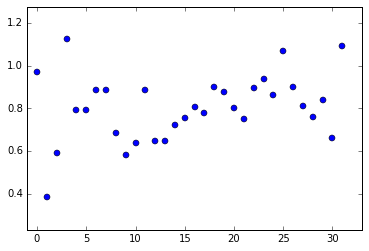

In [29]:
# check workload distribution numerically and graphically
print 'Demand: mean= {0:.2f} | std= {1:.2f}'.format(avgDemand.mean(), avgDemand.std())
print 'Schools per specialist: mean= {0:.2f} | std= {1:.2f} | min= {2:.1f} | max= {3:.1f}'\
.format(avgSchools.mean(), avgSchools.std(), avgSchools.min(), avgSchools.max())
plt.plot(np.array(range(len(avgDemand))), avgDemand, 'ob')
plt.ylim(avgDemand.min()-avgDemand.std(), avgDemand.max()+avgDemand.std())
plt.xlim(-1, len(avgDemand)+1)
plt.show()

#### helper functions for territory allocation model
1. straightline geographic distance
2. K-nearest neighbors
3. Adjacency list (wrapper function for K-nearest neighbors)

In [30]:
# distance function following Haversine formula
# courtesy: https://gist.github.com/rochacbruno/2883505
# future version could use travel time here instead of distance... ambitous.
def geoDist(lat1, lon1, lat2, lon2):
    #print 'lat1 %s | lon1 %s | lat2 %s | lon2 %s' % (lat1, lon1, lat2, lon2)
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [31]:
# wrapper around sklearn's nearest neighbor functionality
# @return: dictionary of {kK, index} for first row of X
def knn(X, XIDs, k):
    n = NN(n_neighbors=k+1) # add 1 to get k nearest neighbors not including self
    D, A = n.fit(X).kneighbors(X, return_distance=True)
    # grab the indexes of first row - probably a way to not calculate all the other combinations...
    Aout = [XIDs[a] for a in A[0,1:]]
    kNN = {'ID': Aout, 'Dist': D[0,1:]}
    return kNN

In [32]:
# adjacency list of two DataFrame inputs
# assumes both have lat/lon columns
# also updates df1 to include calculated k-nearest neighbors with ID and distance
# @return DataFrame with same index and k NN columns
def getAdjacencyList(df1, df2, k = 5):
    
    # call with df's apply function - can't figure it out, looping through
    #X = df1.loc[:,('lat','lon')].values
    # add output columns
    keys = ['k'+str(i) for i in range(k)]
    for kN in keys:
        df1[kN] = 0
        df1[kN+'_dist'] = 0
    # iterate through rows 
    for i, r in df1.iterrows():
        tX = np.concatenate(([np.array([r.lat, r.lon])],df2[df2.index!=i].loc[:,('lat', 'lon')].values))
        XIDs = np.concatenate((np.array([i]),df2[df2.index!=i].index.values))
        kNN_res = knn(tX, XIDs, k)
        # update output's columns
        for j, kN in enumerate(keys):
            df1.loc[i,kN] = kNN_res['ID'][j]
            df1.loc[i,kN+'_dist'] = kNN_res['Dist'][j]
            
    # return df1's kNN columns:
    return df1.iloc[:,-len(keys)*2:]

### Within District assignments
+ assign schools to individual specialists

In [33]:
# full within district allocation function
# assumes 'districtAssign' and 'specialistAssignments' already created
# @return: territory summary ('gCenter') DataFrame to add to 'districtAssign' dictionary
def territoryAllocation(districtCode):
    ##### step 1: cluster schools by location
    # get agent list for this district
    dAgents = districtAssign[districtCode]['agents']
    # set number of territories to create
    km = KMeans(len(dAgents))
    # create temporory dataframe of schools in this district
    tmp = gpd.GeoDataFrame(schools[schools.GEO_DISTRI==districtCode].loc[:,('LOC_CODE', 'lat','lon', 'geometry', 
                                                                 'Total Enrollment')])
    # create initial territory assignments
    tmp['group'] = km.fit_predict(tmp.loc[:,('lat', 'lon')])
    
    ##### step 2: calculate center points of group and schools' distances to their group
    gCenters = tmp.groupby(['group'])['lat', 'lon'].mean()
    tmp['gDist'] = tmp.apply(lambda x: geoDist(x.lat, x.lon, 
                                               gCenters.loc[x.group:x.group,'lat'].values[0], 
                                               gCenters.loc[x.group:x.group,'lon'].values[0]),
                             axis=1)
    
    #### step 3a: update groups' totals and order by workload
    gCenters = pd.merge(gCenters, tmp.groupby('group')['Total Enrollment'].agg({'TotalEnrollment': 'sum', 
                                                                           'NumSchools': 'count'}),
                   left_index=True, right_index=True)
    
    #### step 3b: try to ensure initial assignments less than maximum allowed, 
    c = 0 # counter to stop while loop from just pushing schools back and forth
    maxVal = gCenters.NumSchools.max()
    while (maxVal > MaxSchoolsPerMonth) & (c < 50):
        maxG = gCenters.NumSchools.idxmax()
        # nearest other group
        gX = np.concatenate((gCenters.loc[maxG:maxG, ('lat', 'lon')].values,
                              tmp[tmp.group!=maxG].loc[:,('lat', 'lon')].values))
        gIDs = np.concatenate((np.array([maxG]),tmp[tmp.group!=maxG].index.values))
        gKNN = knn(gX, gIDs, 1)['ID'][0]
        #print 'pre', gKNN, tmp.loc[gKNN, 'group']
        newG = tmp.loc[gKNN, 'group']
        #print 'iteration {0} | maxG: {1} | newG: {2}'.format(c, maxG, newG)
        # nearest school to that group's center
        gX = np.concatenate((gCenters.loc[newG:newG, ('lat', 'lon')].values,
                              tmp[tmp.group==maxG].loc[:,('lat', 'lon')].values))
        gIDs = np.concatenate((np.array([maxG]),tmp[tmp.group==maxG].index.values))
        gKNN = knn(gX, gIDs, 1)['ID'][0]
        tmp.loc[gKNN, 'group'] = newG
        #print 'post', tmp.loc[gKNN, 'group']
        gCenters = tmp.groupby(['group'])['lat', 'lon'].mean()
        gCenters = pd.merge(gCenters, tmp.groupby('group')['Total Enrollment'].agg({'TotalEnrollment': 'sum', 
                                                                               'NumSchools': 'count'}),
                       left_index=True, right_index=True)
        maxVal = gCenters.NumSchools.max() # reset max value for new assignment
        c += 1 # increment counter

    gCenters.sort_values('TotalEnrollment', ascending=False, inplace=True)
    
    # 4) reassign schools to even out agent's workload
    # eventually this is where minimization will come in... somehow
    # logic:
    ### a. begin with highest workload group -> 'candidates'
    ### b. identify schools farthest from group that 
    ######## (0) are in an 'adjacent' cluster - build in room for flexible adjacency criteria
    ######## (i) are closer to other group than *this* group's center point
    ######## (ii) when removed will not reduce my group's workload to below District's mean
    ### c. assign identified points to nearest *other* group(s)

    def shiftWorkload(maxGroup, groupCol, distCol):
        # potential candidates are any location in this group, start with those farthest from group's centroid
        candidates = tmp[tmp[groupCol]==maxGroup].sort_values(distCol, ascending=False)
        candidates['Selected'] = 0 # column to pass through step (b) of logic
        #candidates['pDist'] = tmp.gDist.max() # column to hold distance to potential reassignment
        candidates['pGroup'] = maxGroup # column to update if passes through logic

        # b.ii break criteria
        groupCutoff = candidates['Total Enrollment'].sum() - gCenters.TotalEnrollment.mean()
        wlShift = 0 # keep track of how much workload we're transfering

        if groupCutoff < 0:
            return 'below average group: %s' % (maxGroup)

        # identify potential groups to which candidates can be reassigned
        if len(gCenters) < 3:
            adjGroups = gCenters[gCenters.index!=maxGroup].index.values
        else:
            # TO DO: improve logic for large groups of territories, 
            # this easily results in agents crossing all over the district
            adjList = getAdjacencyList(gCenters, gCenters, len(gCenters)-1)
            adjGroups = adjList.loc[maxGroup,:].values
        others = tmp[tmp[groupCol].isin(adjGroups)]
        
        # check if other groups would go over maximum school cutoff
        trackNumLocs = {}
        for a in gCenters.index.values.tolist():
            trackNumLocs[a] = {}
            trackNumLocs[a]['currNum'] = gCenters.loc[a, 'NumSchools']
            trackNumLocs[a]['added'] = 0

        # TO DO: pull most of this out of the loop(s) and only iterate through the actual reassignment portion
        for i, r in candidates.iterrows():
            # step b.i of reassignment logic
            closer = {} # temporary dict to check distance criteria
            closer['group'] = maxGroup 
            #closer['distance'] = r.gDist
            for iC, rC in others.iterrows():
                # distance from *this candidate* to *this other* location
                d = geoDist(r.lat, r.lon, rC.lat, rC.lon)
                # distance from *this other* to candidate's group center
                groupD = geoDist(gCenters.loc[maxGroup, 'lat'], gCenters.loc[maxGroup, 'lon'], rC.lat, rC.lon)
                # distance from *this candidate's* group center to *this other's* group center
                groupDP = geoDist(gCenters.loc[maxGroup, 'lat'], gCenters.loc[maxGroup, 'lon'], 
                                  gCenters.loc[rC[groupCol], 'lat'], gCenters.loc[rC[groupCol], 'lon'])
                # check if
                # a) candidate is closer to some point in potential new group and
                # b) candidate is closer to old center than potential new center is to old center
                if (d < groupD) & (r.gDist < groupDP):
                    #closer['distance'] = d if d < groupD else closer['distance']
                    closer['group'] = rC.group
            # through other groups' locations, reassign this candidate?
            if closer['group'] != r.group:
                candidates.loc[i, 'Selected'] = 1
                #candidates.loc[i, 'pDist'] = closer['distance']
                candidates.loc[i, 'pGroup'] = closer['group']
            #print 'i= {0} | closestGroup {1} | closestDist {2:.3f}'.format(i, closer['group'], closer['distance'])

            # step b.ii of reassignment logic
            if candidates.loc[i, 'Selected']==0:
                continue # this candidate was not selected in step b.i, skip
            else:
                # if record would not drop group below cutoff value so AND 
                # if would not bump schools over maximum number
                totLocs = trackNumLocs[closer['group']]['currNum']+trackNumLocs[closer['group']]['added']
                if (wlShift+r['Total Enrollment'] <= groupCutoff) and (totLocs < MaxSchoolsPerMonth):
                    wlShift += r['Total Enrollment'] # increment value to shift
                    trackNumLocs[a]['added'] += 1 # increment number of schools added to other group
                    # if made here can reassign group
                    tmp.loc[i, 'group'] = candidates.loc[i, 'pGroup']
                else: # else reset 'Selected' then continue to next record
                    candidates.loc[i, 'Selected'] = 0
                    
        return 'tmp updated with reassigned schools for group %s' % (maxGroup)
    
    # reculate territories
    for i, r in gCenters.iterrows():
        shiftWorkload(i, 'group', 'gDist')
        
    # recalculate gCenters with new data
    gCenters = tmp.groupby(['group'])['lat', 'lon'].mean()
    gCenters = pd.merge(gCenters, tmp.groupby('group')['Total Enrollment'].agg({'TotalEnrollment': 'sum', 
                                                                               'NumSchools': 'count'}),
                       left_index=True, right_index=True)

    # and recalculate distances from each school to it's new group centroid
    tmp['gDist'] = tmp.apply(lambda x: geoDist(x.lat, x.lon,
                              gCenters.loc[x.group:x.group,'lat'].values[0], 
                              gCenters.loc[x.group:x.group,'lon'].values[0]),
                         axis=1)

    #### step 5: setup output
    # add agent key to grouped assignments
    gCenters['agentID'] = ''
    for i, r in gCenters.iterrows():
        gCenters.loc[i, 'agentID'] = dAgents[i]
        # summarize workload
        specialistAssignments[dAgents[i]]['SchoolSummary'] = tmp[tmp.group==i].\
groupby('group')['Total Enrollment'].\
agg({'AvgNeed': 'mean', 'MinNeed': 'min', 'MaxNeed': 'max',
     'TotalNeed': 'sum', 'StDevNeed': 'std', 'NumSchools': 'count'})
        specialistAssignments[dAgents[i]]['SchoolSummary'].reset_index(inplace=True)
        specialistAssignments[dAgents[i]]['SchoolSummary']['group'] = dAgents[i]
        specialistAssignments[dAgents[i]]['SchoolSummary'].set_index('group',inplace=True)
        # summarize distances
        specialistAssignments[dAgents[i]]['DistanceSummary'] = tmp[tmp.group==i].\
groupby('group')['gDist'].\
agg({'AvgDistance': 'mean', 'MinDistance': 'min', 'MaxDistance': 'max',
     'TotalDistance': 'sum', 'StDevDistance': 'std'})
        specialistAssignments[dAgents[i]]['DistanceSummary'].reset_index(inplace=True)
        specialistAssignments[dAgents[i]]['DistanceSummary']['group'] = dAgents[i]
        specialistAssignments[dAgents[i]]['DistanceSummary'].set_index('group',inplace=True)
        # add list of school codes this agents serves
        specialistAssignments[dAgents[i]]['SchoolList'] = tmp[tmp.group==i].LOC_CODE.values
        
    ### return center points (territory summary) for this district
    return gCenters

In [34]:
# iterate though all districts, allocating territories and adding territory summary for each district
import time
for d in districtAssign.keys():
    # realign territory
    start_t = time.time()
    districtAssign[d]['terrSummary'] = territoryAllocation(d)
    print 'finished territory allocation for district %d in %g seconds' % (d, time.time()-start_t)

finished territory allocation for district 1 in 0.379957 seconds
finished territory allocation for district 2 in 6.06897 seconds
finished territory allocation for district 3 in 0.611998 seconds
finished territory allocation for district 4 in 0.477989 seconds
finished territory allocation for district 5 in 0.874981 seconds
finished territory allocation for district 6 in 1.12744 seconds
finished territory allocation for district 7 in 1.18897 seconds
finished territory allocation for district 8 in 1.93989 seconds
finished territory allocation for district 9 in 2.10985 seconds
finished territory allocation for district 10 in 4.16253 seconds
finished territory allocation for district 11 in 3.3654 seconds
finished territory allocation for district 12 in 1.41154 seconds
finished territory allocation for district 13 in 1.20108 seconds
finished territory allocation for district 14 in 1.13865 seconds
finished territory allocation for district 15 in 1.06382 seconds
finished territory allocation f

### Territory reporting metrics
+ summary of school 'need' metric - here just total enrollment
+ summary of distances between specialists' school assignments
+ map visualization of resulting territories

In [35]:
# collect and combine territory summaries for each specialist
workloadSummary = []
distanceSummary = []
for s in specialistAssignments.keys():
    workloadSummary.append(specialistAssignments[s]['SchoolSummary'])
    distanceSummary.append(specialistAssignments[s]['DistanceSummary'])
    
workloadSummary = pd.concat(workloadSummary)
distanceSummary = pd.concat(distanceSummary)

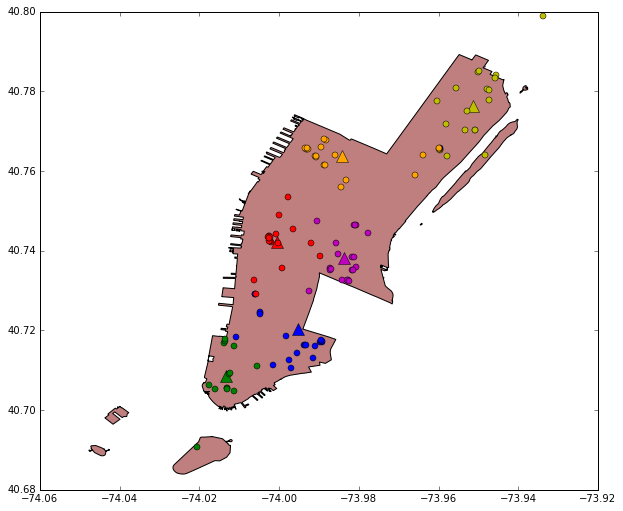

In [36]:
# sample of territory output map
dTid = 2

# subset summary territory data
dTerrC = districtAssign[dTid]['terrSummary'] # territory centroid dataframe

ax = gpd.GeoDataFrame(nysd[nysd.SchoolDist==dTid]).plot(figsize=(10,10))
cols = ['m', 'y', 'b', 'orange', 'r', 'g', 'black']
for i, terr in dTerrC.iterrows():
    ax.plot(terr.lon, terr.lat, '^', markersize=12, c=cols[i])
    # subset associated schools
    terrSchools = schools[schools.LOC_CODE.isin(specialistAssignments[terr['agentID']]['SchoolList'])]
    ax.plot(terrSchools.lon, terrSchools.lat, 'o', c=cols[i])

In [37]:
dTerrC # green record from above map is 6th (last) record - s045 has one school up by blue territory

,lat,lon,TotalEnrollment,NumSchools,agentID
group,,,,,
0,40.738075,-73.983761,10049,20,s040
1,40.776315,-73.951307,10259,19,s041
2,40.720338,-73.995305,9806,22,s042
3,40.763788,-73.984242,10119,20,s043
4,40.742094,-74.000562,10830,19,s044
5,40.708614,-74.013364,10332,14,s045


In [38]:
distanceSummary.loc[['s0'+str(s) for s in range(40,46)],:] 
# that far away school looks to be roughly 5.8km, about 3.6 miles

,StDevDistance,AvgDistance,MaxDistance,TotalDistance,MinDistance
group,,,,,
s040,0.320486,0.597394,1.188841,11.947878,0.172575
s041,0.596525,0.964753,2.922085,18.330311,0.182044
s042,1.122944,1.026761,5.869956,22.588738,0.319179
s043,0.547972,0.863152,2.071613,17.263037,0.145948
s044,0.443805,0.512834,1.498966,9.743851,0.040675
s045,0.507844,0.653462,2.069440,9.148463,0.086943


> Example for district 2 (above) shows difficulty of combined spatial and workload territory balancing - s045 has the lowest 'workload' (number of enrolled students) but 
>> a. slightly more than the maximum number of schools and 
>>
>> b. there is one school that is far away, past 3 other territories

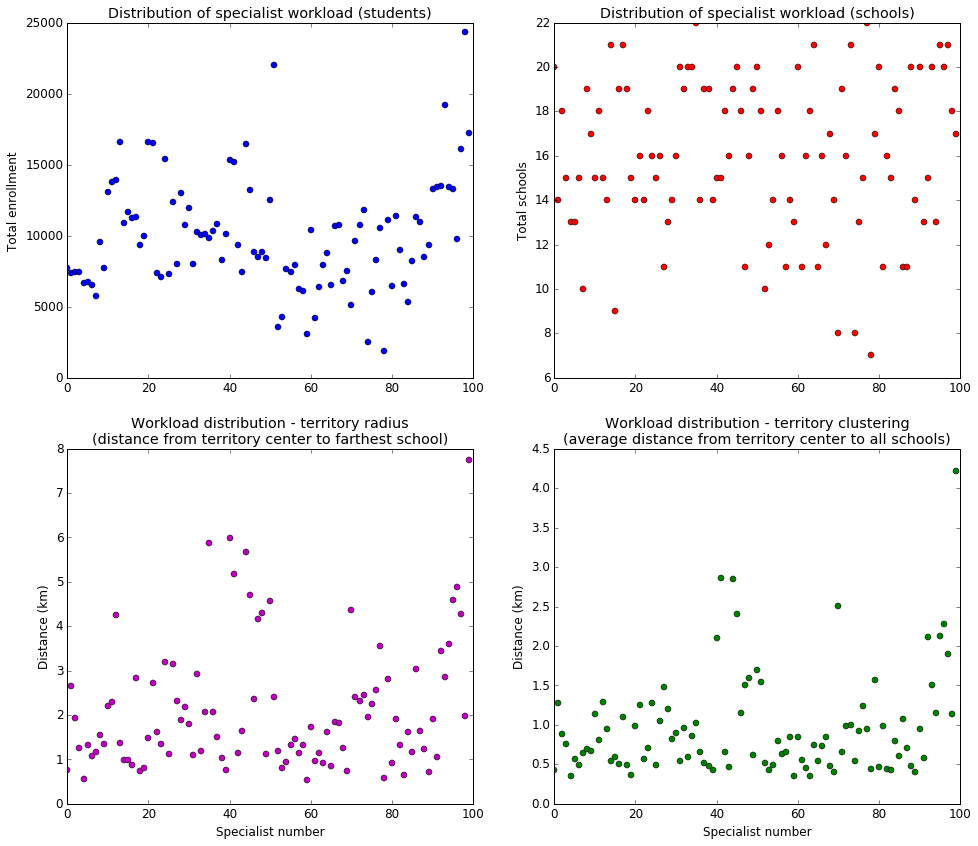

In [39]:
plt.rcParams.update({'font.size': 12})
f = plt.figure(figsize=(16,14))

# x-axis same on all below plots, the specialist/territory to be plotted
x = range(len(sKeys))

# enrollment totals
ax = f.add_subplot(221)
ax.plot(x, workloadSummary.TotalNeed, 'ob')
ax.set_title('Distribution of specialist workload (students)')
ax.set_ylabel('Total enrollment')
#ax.set_xlabel('Specialist number')

# school counts
ax1 = f.add_subplot(222)
ax1.plot(x, workloadSummary.NumSchools, 'or')
ax1.set_title('Distribution of specialist workload (schools)')
ax1.set_ylabel('Total schools')
#ax1.set_xlabel('Specialist number')

# Distance - farthest school (ie territory radius)
ax2 = f.add_subplot(223)
ax2.plot(x, distanceSummary.MaxDistance, 'om')
ax2.set_title('Workload distribution - territory radius\n(distance from territory center to farthest school)')
ax2.set_ylabel('Distance (km)')
ax2.set_xlabel('Specialist number')

# Distance - avg school distance (ie territory clustering)
ax2 = f.add_subplot(224)
ax2.plot(x, distanceSummary.AvgDistance, 'og')
ax2.set_title('Workload distribution - territory clustering\n(average distance from territory center to all schools)')
ax2.set_ylabel('Distance (km)')
ax2.set_xlabel('Specialist number')

In [40]:
# territories that resulted in more than max school cutoff
workloadSummary[workloadSummary.NumSchools>20]

,AvgNeed,NumSchools,TotalNeed,MinNeed,StDevNeed,MaxNeed
group,,,,,,
s067,518.761905,21,10894,201,250.230874,1156
s064,539.714286,21,11334,238,287.759299,1419
s042,445.727273,22,9806,68,230.097119,970
s010,419.000000,21,8799,72,222.528875,806
s091,563.666667,21,11837,197,336.785293,1484
s095,478.727273,22,10532,193,239.960549,955
s086,631.714286,21,13266,370,181.432120,1060
s080,767.285714,21,16113,255,449.170140,1950


In [41]:
# s081 appears to have many schools and a very high workload - what's going on there?
print 'District', specialistAssignments['s081']['district']
districtAssign[specialistAssignments['s081']['district']]['terrSummary']

District 27


,lat,lon,TotalEnrollment,NumSchools,agentID
group,,,,,
0,40.687661,-73.831002,16113,21,s080
1,40.596779,-73.779297,9795,20,s081
2,40.645705,-73.833086,17204,17,s082


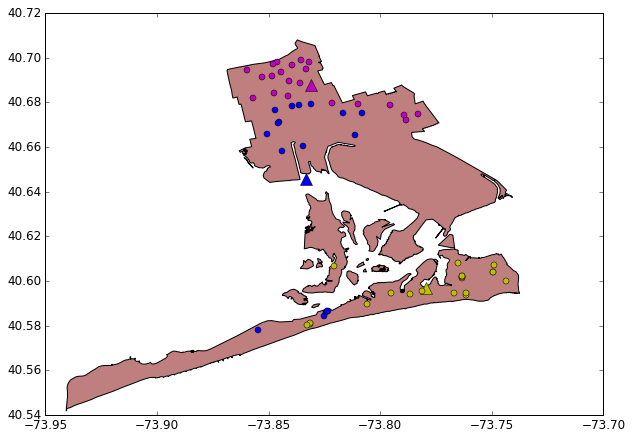

In [42]:
# territory output map for this district (27)
dTid = specialistAssignments['s081']['district']

# subset summary territory data
dTerrC = districtAssign[dTid]['terrSummary'] # territory centroid dataframe

ax = gpd.GeoDataFrame(nysd[nysd.SchoolDist==dTid]).plot(figsize=(10,10))
cols = ['m', 'y', 'b', 'orange', 'r', 'g', 'black']
for i, terr in dTerrC.iterrows():
    ax.plot(terr.lon, terr.lat, '^', markersize=12, c=cols[i])
    # subset associated schools
    terrSchools = schools[schools.LOC_CODE.isin(specialistAssignments[terr['agentID']]['SchoolList'])]
    ax.plot(terrSchools.lon, terrSchools.lat, 'o', c=cols[i])

In [43]:
# territories with lowest 20% number of schools
workloadSummary[workloadSummary.NumSchools<np.percentile(workloadSummary.NumSchools, 20)]

,AvgNeed,NumSchools,TotalNeed,MinNeed,StDevNeed,MaxNeed
group,,,,,,
s077,578.500000,10,5785,216,372.370559,1438
s066,1293.555556,9,11642,636,720.247199,3010
s053,729.090909,11,8020,367,271.127444,1108
s031,774.000000,11,8514,405,383.789526,1517
s027,353.900000,10,3539,31,230.865257,828
s026,358.083333,12,4297,141,176.537124,751
s022,564.545455,11,6210,129,372.147649,1274
s019,379.000000,11,4169,77,254.310833,809
s011,594.454545,11,6539,303,247.658783,1064


### get full territory assignment by school

In [60]:
#for i, spec in specialistAssignments.iteritems():
    #print 'i', i, 'keys', spec.keys()

In [63]:
schools['specialistID'] = '' # to be updated
# iterate through specialists assigning schools
for i, spec in specialistAssignments.iteritems():
    idx = schools[schools.LOC_CODE.isin(spec['SchoolList'])].index
    schools.loc[idx,'specialistID'] = i

In [71]:
# schools.head()

In [70]:
# export results
schools.loc[:, ('specialistID', 'LOC_CODE', 'GEO_DISTRI', 'lat', 'lon', 
                'Total Enrollment')].to_csv('./specialist_assignments_0310.csv', index=False, index_label=False)